In [1]:
from __future__ import print_function
import argparse
import os
import time
from math import log10
from os.path import join
from torchvision import transforms
from torchvision import utils as utils
import torch
from torch.utils.data import DataLoader
from datasets.dataset_hf5 import DataValSet
import statistics
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['PYTHONWARNINGS'] ="ignore"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_args(args):
    parser = argparse.ArgumentParser(description="PyTorch GFN Test")
    parser.add_argument("--scale", default=4, type=int, help="scale factor, Default: 4")
    parser.add_argument("--gated", type=bool, default=True, help="Activated gate module")
    parser.add_argument("--isTest", type=bool, default=True, help="Test or not")
    parser.add_argument('--dataset', required=False, help='Path of the validation dataset')
    parser.add_argument("--intermediate_process", default="", type=str, help="Test on intermediate pkl (default: none)")
    return parser.parse_args(args)

opt = parse_args([])

def is_pkl(filename):
    return any(filename.endswith(extension) for extension in [".pkl"])

def which_trainingstep_epoch(resume):
    trainingstep = "".join(re.findall(r"\d", resume)[0])
    start_epoch = "".join(re.findall(r"\d", resume)[1:])
    return int(trainingstep), int(start_epoch)
    
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def displayFeature(feature):
    feat_permute = feature.permute(1, 0, 2, 3)
    grid = utils.make_grid(feat_permute.cpu(), nrow=16, normalize=True, padding=10)
    grid = grid.numpy().transpose((1, 2, 0))
    display_grid = grid[:, :, 0]
    plt.imshow(display_grid)

def test(test_gen, model, criterion):
    avg_psnr = 0
    med_time = []

    with torch.no_grad():
        for iteration, batch in tqdm(enumerate(test_gen, 1)):
            LR_Blur = batch[0]
            HR = batch[1]
            LR_Blur = LR_Blur.to(device)
            HR = HR.to(device)

            if opt.isTest == True:
                test_Tensor = torch.cuda.FloatTensor().resize_(1).zero_() + 1
            else:
                test_Tensor = torch.cuda.FloatTensor().resize_(1).zero_()
            if opt.gated == True:
                gated_Tensor = torch.cuda.FloatTensor().resize_(1).zero_() + 1
            else:
                gated_Tensor = torch.cuda.FloatTensor().resize_(1).zero_()

            start_time = time.perf_counter()#-------------------------begin to deal with an image's time
            [lr_deblur, sr] = model(LR_Blur, gated_Tensor, test_Tensor)
            #modify
            sr = torch.clamp(sr, min=0, max=1)
            torch.cuda.synchronize()#wait for CPU & GPU time syn
            evalation_time = time.perf_counter() - start_time#------SR_dirSR_dir---finish an image
            med_time.append(evalation_time)

            # print("Processing {}".format(iteration))
            mse = criterion(sr, HR)
            psnr = 10 * log10(1 / mse)
            avg_psnr += psnr

        print("Avg. SR PSNR:{:4f} dB".format(avg_psnr / iteration))
        median_time = statistics.median(med_time)
        print(median_time)

def get_patch_wise_results(img, hr_img, model):
    lr_img_w, lr_img_h = img.size
    hr_img_w, hr_img_h = hr_img.size

    final_img = np.zeros((hr_img_h,hr_img_w, 3))
    viz_features = np.zeros((lr_img_h,lr_img_w, 3))
    patch_w = 64
    patch_h = 64
    for i in range(0, lr_img_w, patch_w):
        for j in range(0, lr_img_h, patch_h):
            start_x1 = i
            end_x1 = start_x1 + patch_w
            start_y1 = j
            end_y1 = start_y1 + patch_h
            lr_patch = img.crop((start_x1, start_y1, end_x1, end_y1))

            start_x = i*4
            end_x = start_x + patch_w*4
            start_y = j*4
            end_y = start_y + patch_h*4
            hr_patch = hr_img.crop((start_x, start_y, end_x, end_y))
            # print(i,j)
            # print(start_x, start_y, end_x, end_y)

            lr_patch = np.array(lr_patch).reshape(1, 64, 64, 3)
            resultSRDeblur, lr_deblur = do_pred(model, lr_patch)
            # print(lr_deblur.size())
            lr_deblur = lr_deblur.permute(0, 2, 3, 1).cpu().detach().numpy()
            lr_deblur = lr_deblur*255
            # print(lr_deblur.shape, start_y1,end_y1,start_x1,end_x1, viz_features[start_y1:end_y1,start_x1:end_x1].shape)
            viz_features[start_y1:end_y1,start_x1:end_x1] = lr_deblur
            final_img[start_y:end_y, start_x:end_x] = resultSRDeblur
    return final_img, viz_features

def model_test(model, root_val_dir):
    model = model.to(device)
    criterion = torch.nn.MSELoss(size_average=True)
    criterion = criterion.to(device)
    print(opt)
    testloader = DataLoader(DataValSet(root_val_dir), batch_size=4, shuffle=False, pin_memory=False)
    print(len(testloader))
    test(testloader, model, criterion)

def do_pred(model, img):
    img1 = np.transpose(img, (0, 3, 1, 2)) / 255

    LR_Blur = torch.from_numpy(img1)
    LR_Blur = LR_Blur.to(device,  dtype=torch.float)

    test_Tensor = torch.cuda.FloatTensor().resize_(1).zero_() + 1
    gated_Tensor = torch.cuda.FloatTensor().resize_(1).zero_() + 1

    [lr_deblur, sr] = model(LR_Blur, gated_Tensor, test_Tensor)
    #modify
    sr = torch.clamp(sr, min=0, max=1)
    torch.cuda.synchronize()#wait for CPU & GPU time syn

    resultSRDeblur = transforms.ToPILImage()(sr.cpu()[0])

    lr_deblur1 = torch.clamp(lr_deblur, min=0, max=1)
    return resultSRDeblur, lr_deblur1

In [42]:
print("===> Loading model and criterion")
test_dir = 'models/0'
test_list = [x for x in sorted(os.listdir(test_dir)) if is_pkl(x)]
test_list = sorted_alphanumeric(test_list)
print("Available models",test_list)

===> Loading model and criterion
Available models ['GFN_epoch_55.pkl']


In [43]:
j = 55
model = torch.load(join(test_dir, "GFN_epoch_{}.pkl".format(j)))
print("using model", join(test_dir, "GFN_epoch_{}.pkl".format(j)))

using model models/0\GFN_epoch_55.pkl


In [78]:
imgs_folder = r"D:\Git_repos2\CS6350\test_images"
lr_images_folder = join(imgs_folder, "LR")
hr_images_folder = join(imgs_folder, "HR")

img_names = os.listdir(lr_images_folder)
print("Images", img_names)
i = 2
img_name = img_names[i]

img_path = os.path.join(lr_images_folder, img_name)
img = Image.open(img_path)
img = img.resize((img.size[0] -img.size[0]%64, img.size[1] -img.size[1]%64))
print(img.size)
hr_img_path = os.path.join(hr_images_folder, img_name)
hr_img = Image.open(hr_img_path)
hr_img = hr_img.resize((img.size[0]*4, img.size[1]*4))

print(hr_img.size)

Images ['0001.png', '0812.png', '1012.png']
(320, 128)
(1280, 512)


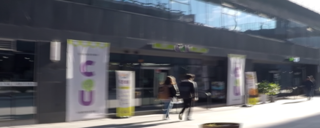

In [79]:
img

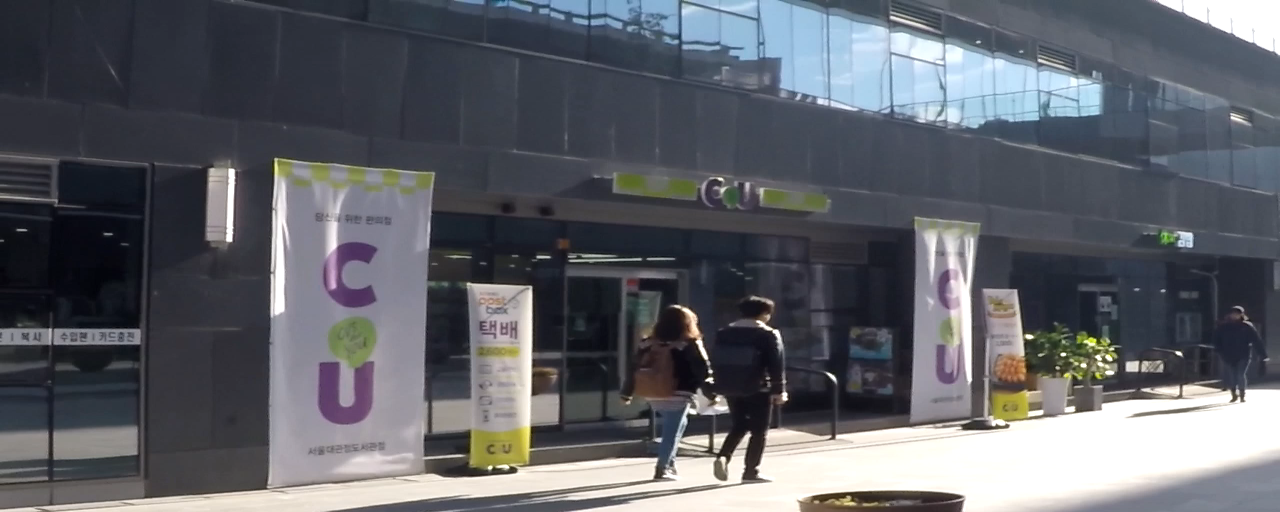

In [80]:
hr_img

In [81]:
final_img, viz_features = get_patch_wise_results(img, hr_img, model)

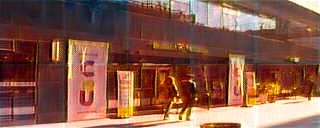

In [82]:
Image.fromarray(viz_features.astype(np.uint8))

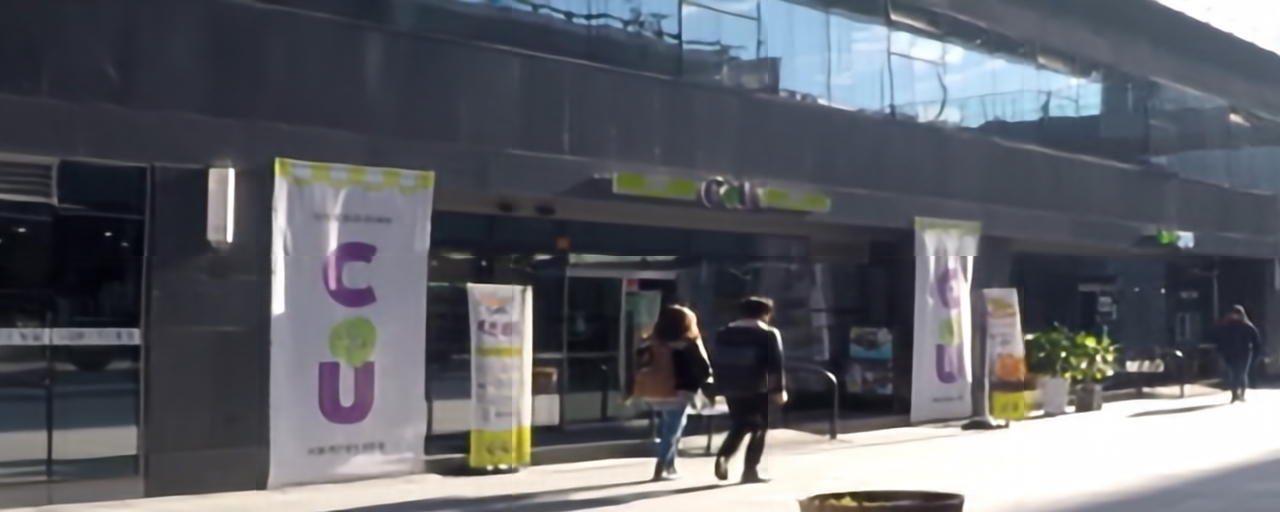

In [83]:
Image.fromarray(final_img.astype(np.uint8))

In [84]:
print("PSNR:",psnr(final_img.astype(np.uint8), np.array(hr_img)))
print("SSIM:",ssim(final_img.astype(np.uint8), np.array(hr_img), multichannel=True))

PSNR: 29.14943732201598
SSIM: 0.9049913601991787


(320, 176)
(1280, 704)


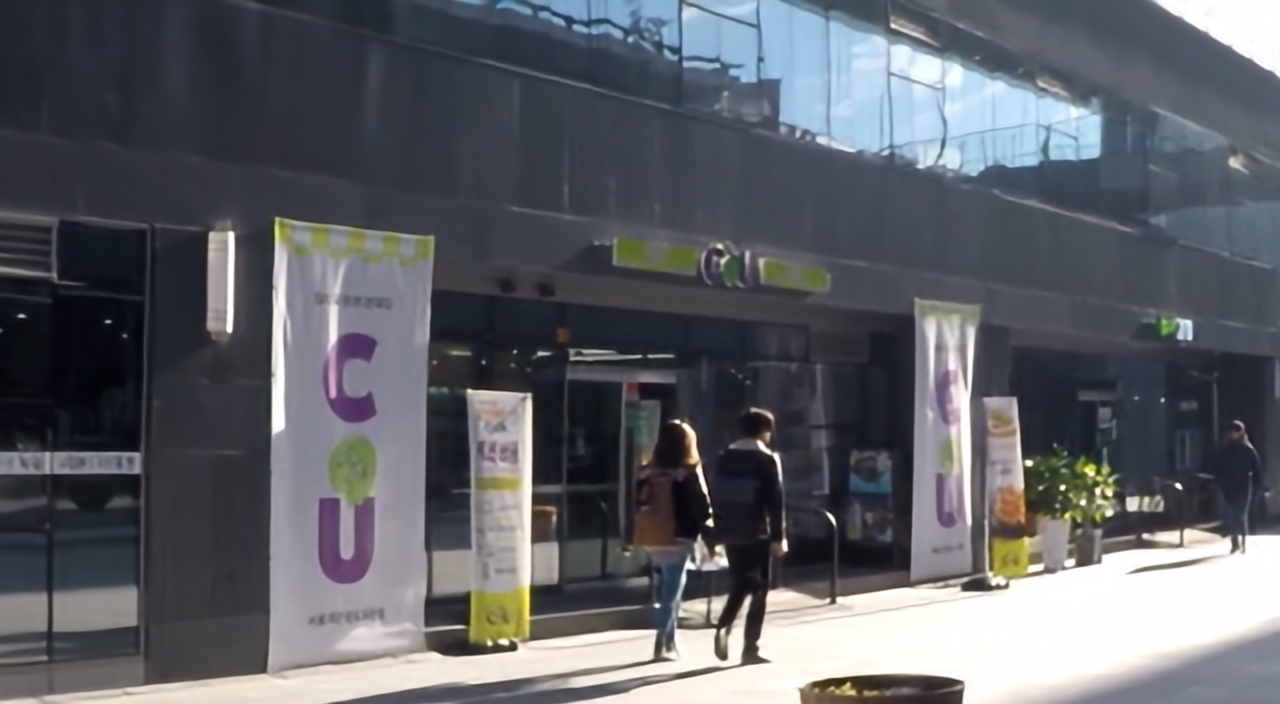

In [85]:
imgs_folder = r"D:\Git_repos2\CS6350\test_images"
lr_images_folder = join(imgs_folder, "LR")
hr_images_folder = join(imgs_folder, "HR")

img_names = os.listdir(lr_images_folder)
img_name = img_names[i]

img_path = os.path.join(lr_images_folder, img_name)
img = Image.open(img_path)
print(img.size)
hr_img_path = os.path.join(hr_images_folder, img_name)
hr_img = Image.open(hr_img_path)
print(hr_img.size)

img1 = np.expand_dims(img, axis=0)
resultSRDeblur, lr_deblur = do_pred(model, img1)
resultSRDeblur

In [86]:
print("PSNR:",psnr(np.array(resultSRDeblur), np.array(hr_img)))
print("SSIM:",ssim(np.array(resultSRDeblur), np.array(hr_img), multichannel=True))

PSNR: 30.183699832041242
SSIM: 0.9205413323358287


(1, 176, 320, 3)


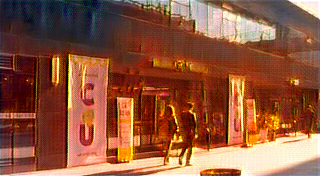

In [87]:
lr_deblur = lr_deblur.permute(0, 2, 3, 1).cpu().detach().numpy()
lr_deblur = lr_deblur*255
print(lr_deblur.shape)
Image.fromarray(lr_deblur[0].astype(np.uint8))

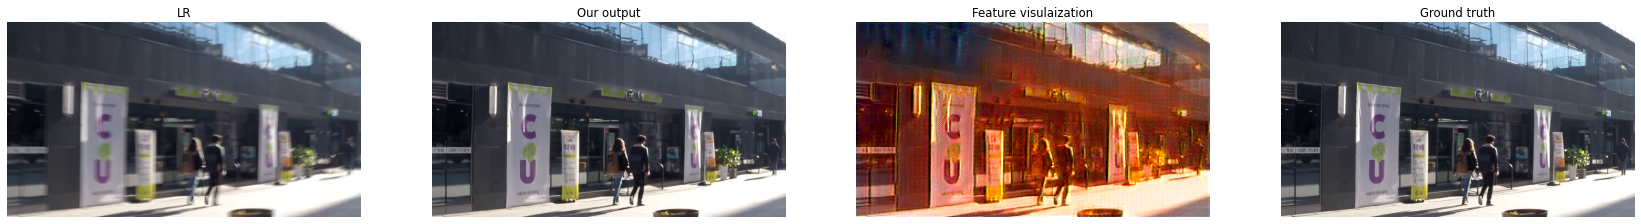

In [88]:
f,axarr = plt.subplots(1,4, figsize=(30,10), dpi = 70)
axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set_title("LR")
axarr[1].imshow(resultSRDeblur)
axarr[1].axis("off")
axarr[1].set_title("Our output")
axarr[2].imshow(Image.fromarray(lr_deblur[0].astype(np.uint8)))
axarr[2].axis("off")
axarr[2].set_title("Feature visulaization")
axarr[3].imshow(hr_img)
axarr[3].axis("off")
axarr[3].set_title("Ground truth")
plt.savefig("results/{}_result.jpg".format(img_name[:-4]))
plt.show()